In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values, n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

In [6]:
# Get Mnist data and split into train validation and test

def get_mnist():
    data=np.float64(np.load('MNIST.npy'))
    labels=np.float32(np.load('MNIST_labels.npy'))
    
    data=np.float32(data)/255.
    
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [7]:
# Get transformed Mnist data

def get_mnist_trans():
    test_trans_dat=np.float32(np.load('MNIST_TEST_TRANS.npy'))
    test_labels=one_hot(np.int32(np.float32(np.load('MNIST_labels.npy'))))
    return (test_trans_dat, test_labels)

In [8]:
# Convolution layer with relu

def conv_relu_layer(input, filter_size=[3,3], num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1], num_features]
    #[Filter size, color, Number of filter]
    
    W = tf.get_variable('W', shape=shape) # Default initialization is Glorot
    b = tf.get_variable('b', shape=[num_features], initializer=tf.zeros_initializer) 
    
    #padding same : same image size after convolution
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME') 
    #(N, 28,28, 32)
    relu = tf.nn.relu(conv + b)
    return(relu)

In [9]:
# Fully connected layer

def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1, flat_dim])
    shape=[flat_dim, num_features]
    
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

In [21]:
# The network

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1] # After pooling, size is not changed
    
    # The network:
    with tf.variable_scope("conv1"):
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5], num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv3"):
            relu3 = conv_relu_layer(pool2, filter_size=[5, 5],num_features=64)
            pool3 = tf.nn.max_pool(relu3, ksize=pool_ksize, strides=[1,1,1,1], padding='SAME')

    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool3, keep_prob)
            
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r = tf.nn.relu(fc1)
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT, LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=fc2), name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="ACC")
        
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [22]:
# Get loss and accuracy on a data set with output from final layer fc2.

# Function to get loss and accuracy from only one run of the feature extraction network
from scipy.special import logsumexp

def get_stats(data,labels):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    #print('Get stats time:',round(time.time()-t1,2),'(s)')
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

In [23]:
# Run one epoch
# Run the iterations of one epoch

def run_epoch(train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            #if (np.mod(j,5000)==0):
            #    print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size], y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        #print('Epoch time    :',round(time.time()-t1,2),'(s)')

In [24]:
#Get the corresponding data

def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

## Run this model 

In [25]:
# Run the training

import time

batch_size=500
step_size=.001
num_epochs=5
num_train=50000 
minimizer="Adam"
model_name="model"
keep_prob=.5

data_set="mnist"; dim=28; nchannels=1

TrainLoss=[]
TrainAccu=[]
ValLoss=[]
ValAccu=[]

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels], name="x") # (N X 784 )
x_image = tf.reshape(x, [-1, dim, dim, nchannels]) #(N X (28 X 28 X 1))
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")   #Label, 0~9
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
    train,val,test=get_data(data_set=data_set)
    
    # Create the network architecture with the above placeholdes as the inputs.
    cross_entropy, accuracy, fc2 = create_network()

    # Define the miminization method
    if (minimizer=="Adam"):
        train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
    elif (minimizer=="SGD"):
        train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Show trainable variables
    for v in tf.trainable_variables():
        print(v.name, v.get_shape().as_list(), np.std(v.eval()))
    ii=np.arange(0,num_train,1)
    print("-------------------------------------------------------")
    
    # Run epochs
    for i in range(num_epochs):  # number of epochs
        run_epoch(train,val,ii,batch_size,train_step)
        lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
        TrainLoss.append(lo)
        print('Epoch:',i,', Train loss     :',round(lo,4), ', Accuracy:',round(ac,4))
        vlo,vac = get_stats(val[0],val[1])
        ValLoss.append(vlo)
        print('Epoch:',i,', Validation loss:',round(vlo,4),', Accuracy:',round(vac,4))
            
    # Test set accuracy
    print("-------------------------------------------------------")
    print('Test accuracy : %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
    
    # Save model
    tf.add_to_collection("optimizer", train_step)
    saver = tf.train.Saver()
    save_path = saver.save(sess, "tmp/"+ model_name)
    print("Model saved in path: %s" % save_path)

conv1/W:0 [5, 5, 1, 32] 0.049731787
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.02887143
conv2/b:0 [64] 0.0
conv3/W:0 [5, 5, 64, 64] 0.024989638
conv3/b:0 [64] 0.0
fc1/W:0 [1024, 256] 0.03953602
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08652788
fc2/b:0 [10] 0.0
-------------------------------------------------------
Epoch: 0 , Train loss     : 0.1104 , Accuracy: 0.9646
Epoch: 0 , Validation loss: 0.094 , Accuracy: 0.9705
Epoch: 1 , Train loss     : 0.0752 , Accuracy: 0.9758
Epoch: 1 , Validation loss: 0.0684 , Accuracy: 0.9782
Epoch: 2 , Train loss     : 0.0548 , Accuracy: 0.9829
Epoch: 2 , Validation loss: 0.05 , Accuracy: 0.9834
Epoch: 3 , Train loss     : 0.0453 , Accuracy: 0.9856
Epoch: 3 , Validation loss: 0.0426 , Accuracy: 0.9863
Epoch: 4 , Train loss     : 0.0325 , Accuracy: 0.9898
Epoch: 4 , Validation loss: 0.038 , Accuracy: 0.9884
-------------------------------------------------------
Test accuracy : 0.9885
Model saved in path: tmp/model


## For each experiment, plot the error rate on training and validation 

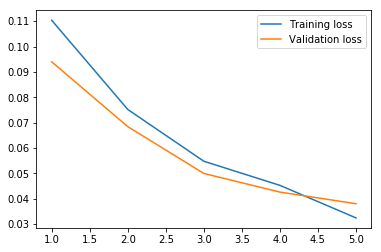

In [26]:
Epoch=range(1,num_epochs+1)
plt.plot(Epoch,TrainLoss)
plt.plot(Epoch,ValLoss)
plt.legend(['Training loss','Validation loss'], loc='upper right')

## Show an image with the 32 5X5 filters in the first layer of the model

In [27]:
with tf.Session() as sess:
    # Get data
    train, val, test=get_data(data_set=data_set)
    # Load model info
    saver = tf.train.import_meta_graph('tmp/'+model_name+'.meta')
    saver.restore(sess,'tmp/'+model_name) 
    graph = tf.get_default_graph()
    
    # Setup the placeholders from the stored model.
    x = graph.get_tensor_by_name('x:0')
    y_= graph.get_tensor_by_name('y:0')
    lr_ = graph.get_tensor_by_name('learning_rate:0')
    keep_prob_ = graph.get_tensor_by_name('keep_prob:0')
    accuracy = graph.get_tensor_by_name('helpers/ACC:0')
    cross_entropy = graph.get_tensor_by_name('cross_entropy_loss/LOSS:0')
    fc2 = graph.get_tensor_by_name('OUT:0')
    
    ConV1Weight=graph.get_collection('trainable_variables')[0].eval()

INFO:tensorflow:Restoring parameters from tmp/model


In [28]:
ConV1Weight.shape

(5, 5, 1, 32)

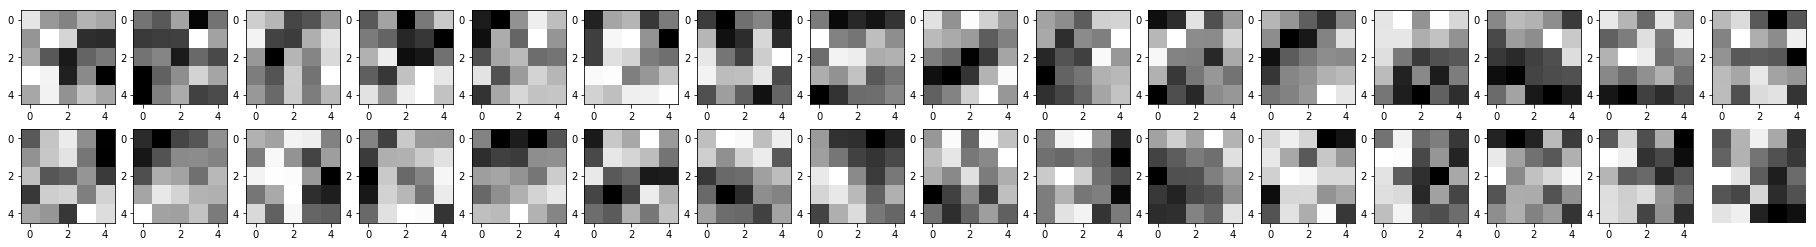

In [29]:
nrows = 2; ncols=16; 
plt.figure(figsize = (ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(ConV1Weight[:,:,0,i].reshape(5,5), cmap='gray')
plt.axis('off')
plt.show()

# Transformed MNIST dataset

## Display a few of these examples alongside the original digits 

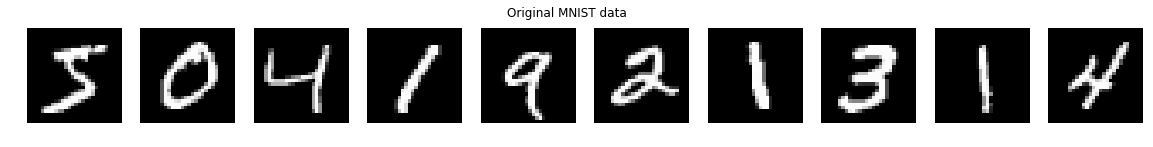

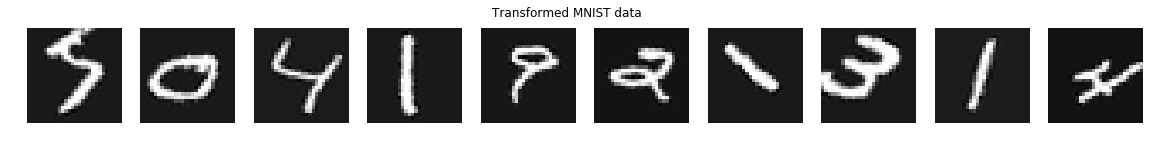

In [30]:
t,v,te = get_data(data_set="mnist")
nrows = 1; ncols=10; 
plt.figure(figsize = (ncols*2, nrows*2))
plt.suptitle('Original MNIST data',fontsize=12)
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(t[0][i,:].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

temp=get_mnist_trans()
plt.figure(figsize = (ncols*2, nrows*2))
plt.suptitle('Transformed MNIST data',fontsize=12)
for i in range(nrows*ncols):  
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(temp[0][i,:].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

## Using the original architecture to test the transformed data 

In [31]:
model_name="model"
with tf.Session() as sess:
    # Get data
    t1, t2 = get_data("mnist_transform")
    # Load model info
    saver = tf.train.import_meta_graph('tmp/'+model_name+'.meta')
    saver.restore(sess,'tmp/'+model_name) 
    graph = tf.get_default_graph()
    # Setup the placeholders from the stored model.
    x = graph.get_tensor_by_name('x:0')
    y_= graph.get_tensor_by_name('y:0')
    lr_ = graph.get_tensor_by_name('learning_rate:0')
    keep_prob_ = graph.get_tensor_by_name('keep_prob:0')
    accuracy=graph.get_tensor_by_name('helpers/ACC:0')
    cross_entropy=graph.get_tensor_by_name('cross_entropy_loss/LOSS:0')
    fc2=graph.get_tensor_by_name('OUT:0')
    
    print('Test accuracy : %g' % accuracy.eval(feed_dict={x: t1[60000:70000], y_:t2[60000:70000]}))

INFO:tensorflow:Restoring parameters from tmp/model
Test accuracy : 0.6577


To compare with the transformed data accuracy with the original data accuracy, I use the transformed data corresponding to the test data set in the original data. We can see that the accuracy of transformed data drops dramatically.